In [51]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import torch
if torch.cuda.is_available():
    import torch.cuda as t
else:
    import torch as t
from torch import nn, optim
from torch.autograd import Variable
from IPython.display import Audio
from scipy.io import wavfile

class One_Hot(nn.Module):
    def __init__(self, depth):
        super(One_Hot,self).__init__()
        self.depth = depth
        self.ones = t.sparse.torch.eye(depth)
    def forward(self, X_in):
        return Variable(self.ones.index_select(0,X_in.data))
    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.depth)

## Wavenet  class
Two generation functions are included. generate_slow( ) is easy to understand, but generate( ) is much faster.

In [64]:
class WaveNet(nn.Module):
    def __init__(self, mu=256,n_residue=32, n_skip= 512, dilation_depth=10, n_repeat=5):
        # mu: audio quantization size
        # n_residue: residue channels
        # n_skip: skip channels
        # dilation_depth & n_repeat: dilation layer setup
        super(WaveNet, self).__init__()
        self.dilation_depth = dilation_depth
        dilations = self.dilations = [2**i for i in range(dilation_depth)] * n_repeat
        self.one_hot = One_Hot(mu)
        self.from_input = nn.Conv1d(in_channels=mu, out_channels=n_residue, kernel_size=1)
        self.conv_sigmoid = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=2, dilation=d)
                         for d in dilations])
        self.conv_tanh = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=2, dilation=d)
                         for d in dilations])
        self.skip_scale = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_skip, kernel_size=1)
                         for d in dilations])
        self.residue_scale = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=1)
                         for d in dilations])
        self.conv_post_1 = nn.Conv1d(in_channels=n_skip, out_channels=n_skip, kernel_size=1)
        self.conv_post_2 = nn.Conv1d(in_channels=n_skip, out_channels=mu, kernel_size=1)
        
    def forward(self, input):
        output = self.preprocess(input)
        output = output
        skip_connections = [] # save for generation purposes
        for s, t, skip_scale, residue_scale in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale):
            output, skip = self.residue_forward(output, s, t, skip_scale, residue_scale)
            skip_connections.append(skip)
        # sum up skip connections
        output = sum([s[:,:,-output.size(2):] for s in skip_connections])
        output = self.postprocess(output)
        return output
    
    def preprocess(self, input):
        output = self.one_hot(input).unsqueeze(0).transpose(1,2)
        output = self.from_input(output.cuda())
        return output
    
    def postprocess(self, input):
        output = nn.functional.elu(input)
        output = self.conv_post_1(output)
        output = nn.functional.elu(output)
        output = self.conv_post_2(output).squeeze(0).transpose(0,1)
        return output
    
    def residue_forward(self, input, conv_sigmoid, conv_tanh, skip_scale, residue_scale):
        output = input
        output_sigmoid, output_tanh = conv_sigmoid(output), conv_tanh(output)
        output = nn.functional.sigmoid(output_sigmoid) * nn.functional.tanh(output_tanh)
        skip = skip_scale(output)
        output = residue_scale(output)
        output = output + input[:,:,-output.size(2):]
        return output, skip
    
    def generate_slow(self, input, n=100):
        res = input.data.tolist()
        for _ in range(n):
            x = Variable(t.LongTensor(res[-sum(self.dilations)-1:]))
            y = self.forward(x)
            _, i = y.max(dim=1)
            res.append(i.data.tolist()[-1])
        return res
    
    def generate(self, input=None, n=100, temperature=None, estimate_time=False):
        ## prepare output_buffer
        output = self.preprocess(input)
        output_buffer = []
        for s, t_, skip_scale, residue_scale, d in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale, self.dilations):
            output, _ = self.residue_forward(output, s, t_, skip_scale, residue_scale)
            sz = 1 if d==2**(self.dilation_depth-1) else d*2
            output_buffer.append(output[:,:,-sz-1:-1])
        ## generate new 
        res = input.data.tolist()
        for i in range(n):
            output = Variable(torch.cuda.LongTensor(res[-2:]))
            output = self.preprocess(output)
            output_buffer_next = []
            skip_connections = [] # save for generation purposes
            for s, t, skip_scale, residue_scale, b in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale, output_buffer):
                output, residue = self.residue_forward(output, s, t, skip_scale, residue_scale)
                output = torch.cat([b, output], dim=2)
                skip_connections.append(residue)
                if i%100==0:
                    output = output.clone()
                output_buffer_next.append(output[:,:,-b.size(2):])
            output_buffer = output_buffer_next
            output = output[:,:,-1:]
            # sum up skip connections
            output = sum(skip_connections)
            output = self.postprocess(output)
            if temperature is None:
                _, output = output.max(dim=1)
            else:
                output = output.div(temperature).exp().multinomial(1).squeeze()
            res.append(output.data[-1])
        return res

## test network forward( )

In [53]:
net = WaveNet(mu=128)
net.cuda()
batch = Variable(torch.from_numpy(np.random.randint(0,128,10000).astype(np.long)))
net(batch)

Variable containing:
 2.3047e-01 -1.4864e-01 -4.4656e-02  ...   6.0907e-01 -3.2161e-01  1.5814e-01
 2.1309e-01 -1.3786e-01 -1.9807e-02  ...   6.3033e-01 -3.1798e-01  1.5393e-01
 2.1829e-01 -1.5072e-01 -5.8914e-02  ...   5.6637e-01 -3.6247e-01  1.3687e-01
                ...                   ⋱                   ...                
 2.4871e-01 -1.8330e-01 -1.1055e-02  ...   6.3584e-01 -3.3515e-01  1.8173e-01
 2.1954e-01 -1.8701e-01 -5.9309e-02  ...   5.8955e-01 -3.2001e-01  1.3987e-01
 2.1531e-01 -1.9204e-01 -1.6486e-03  ...   5.8274e-01 -3.4426e-01  1.3730e-01
[torch.cuda.FloatTensor of size 4885x128 (GPU 0)]

## test generation

- generate_slow( ) is easy to understand
- generate( ) is faster than generate_slow( )

In [65]:
%time y_gen = net.generate(batch, 20)
%time y_gen2 = net.generate_slow(batch, 20)

AttributeError: 'Conv1d' object has no attribute 'LongTensor'

TypeError: index_select received an invalid combination of arguments - got (int, !torch.cuda.LongTensor!), but expected (int dim, torch.LongTensor index)

In [ ]:
y_gen[-5:], y_gen2[-5:]

## $\mu$-law encode and decode

In [6]:
def encode_mu_law(x, mu=256):
    mu = mu-1
    fx = np.sign(x)*np.log(1+mu*np.abs(x))/np.log(1+mu)
    return np.floor((fx+1)/2*mu+0.5).astype(np.long)

def decode_mu_law(y, mu=256):
    mu = mu-1
    fx = (y-0.5)/mu*2-1
    x = np.sign(fx)/mu*((1+mu)**np.abs(fx)-1)
    return x  

## sine wave generator

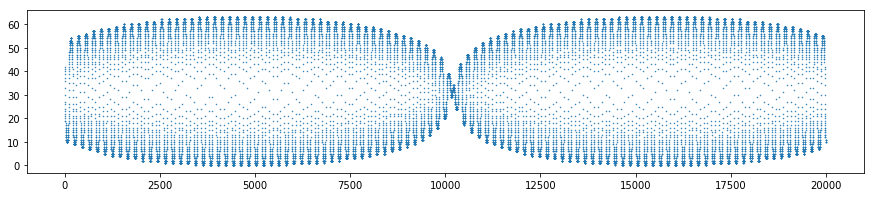

In [8]:
def sine_generator(seq_size = 6000, mu=256):
    framerate = 44100
    t = np.linspace(0,5,framerate*5)
    data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
    data = data/2
    while True:
        start = np.random.randint(0,data.shape[0]-seq_size)
        ys = data[start:start+seq_size]
        ys = encode_mu_law(ys,mu)
        yield Variable(torch.from_numpy(ys[:seq_size]))
        
g = sine_generator(mu=64, seq_size=20000)
x = next(g)
plt.figure(figsize=[15,3])
plt.plot(x.data.tolist(),'.', ms=1)

## listen to the signal

In [9]:
y = x.data.numpy()
y = decode_mu_law(y, 64)
Audio(y,rate=44100)

## network training

This network tries to generate the vibrating sine wave above. 
- The audio signal is quantized to 64 discrete integers.
- 24 channels in residue outputs
- 128 channels in skip outputs
- 20 dilation layers (n_repeat=2, dilation_depth=10)

epoch 0, loss 4.212542533874512


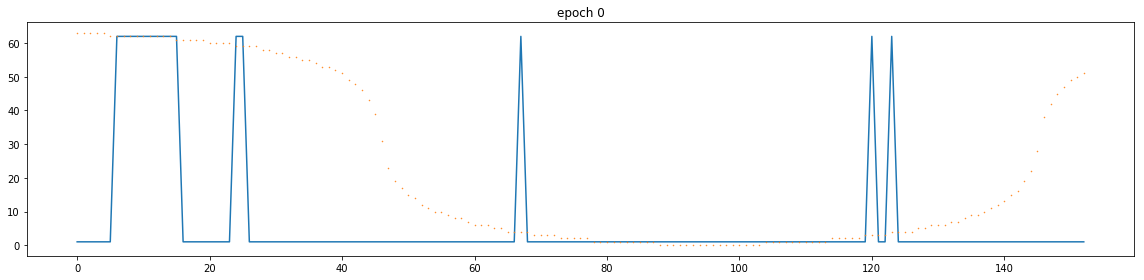

epoch 100, loss 0.3004100024700165


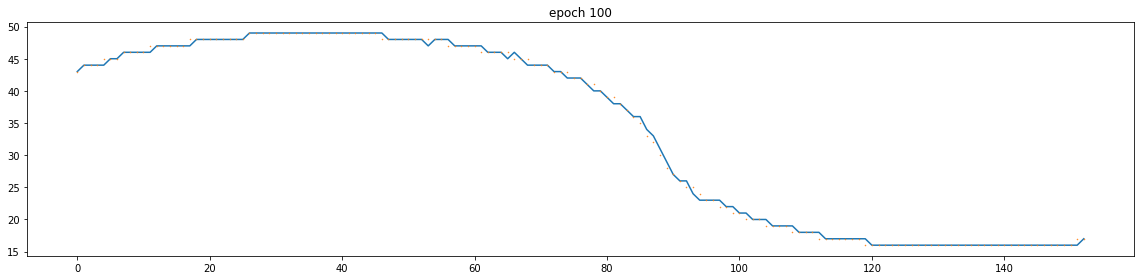

epoch 200, loss 0.17471250891685486


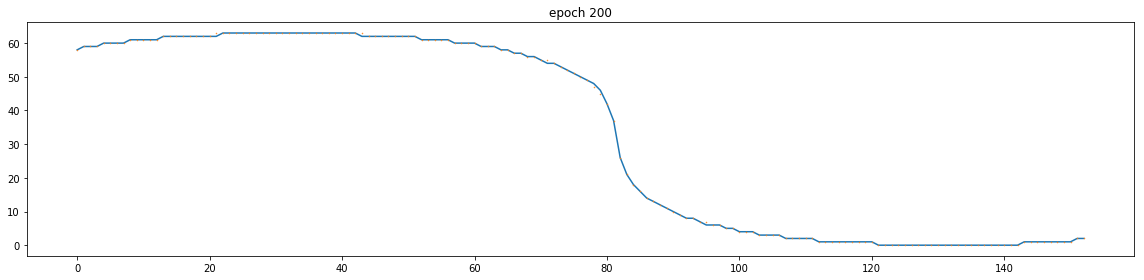

epoch 300, loss 0.12783077359199524


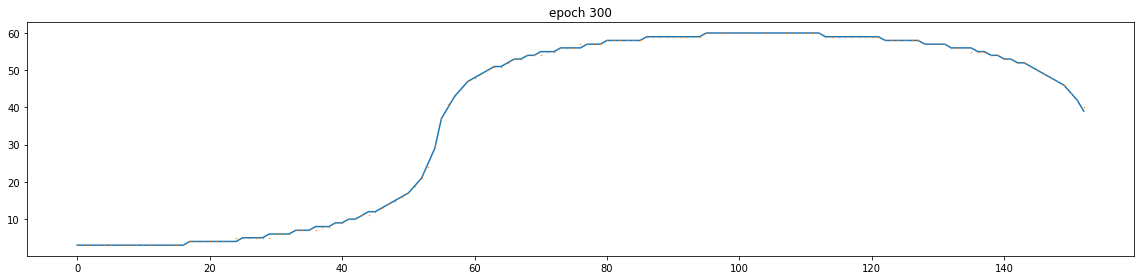

epoch 400, loss 0.11958552151918411


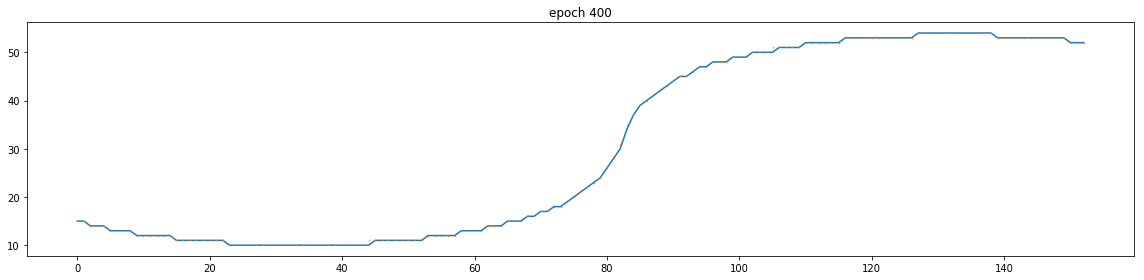

epoch 500, loss 0.09312139451503754


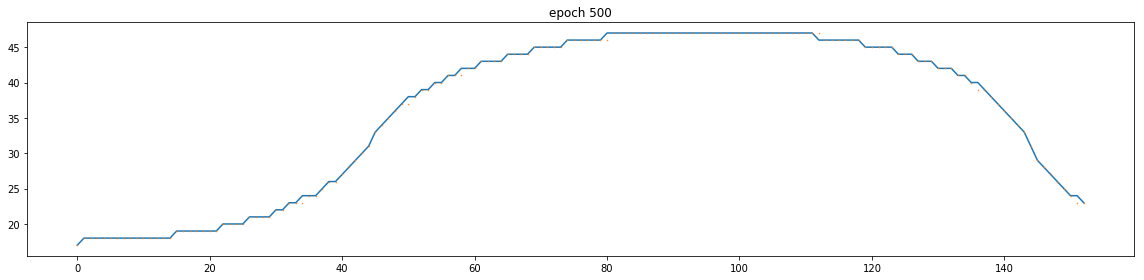

epoch 700, loss 0.09115851670503616


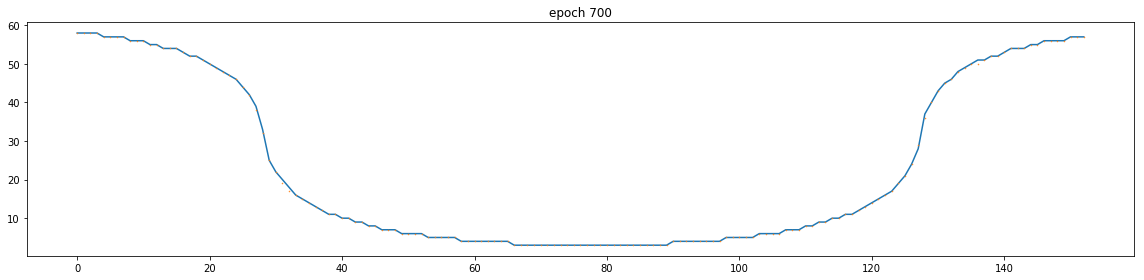

epoch 800, loss 0.08244013786315918


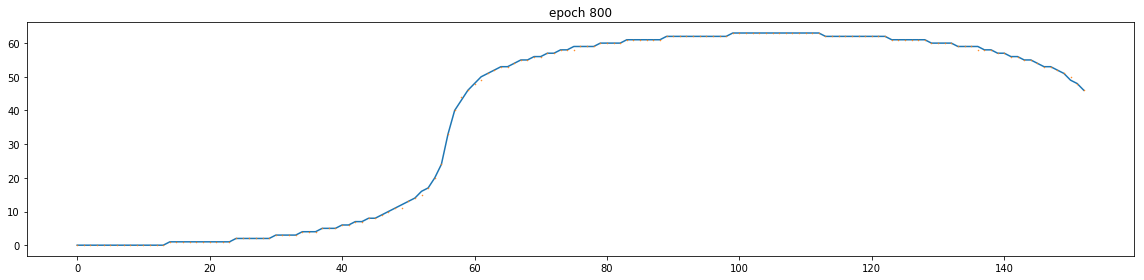

epoch 900, loss 0.08408812433481216


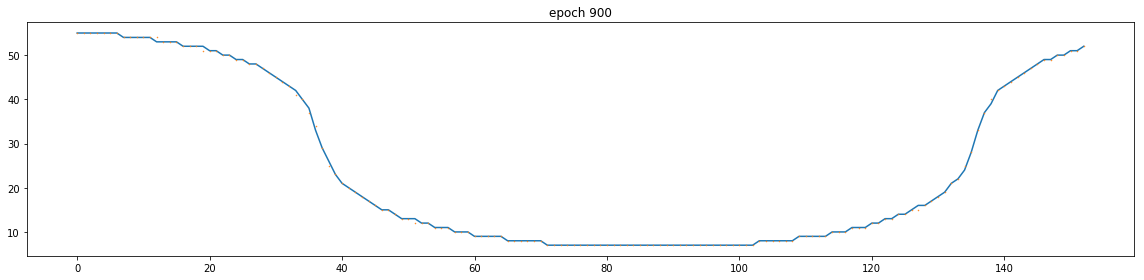

epoch 1000, loss 0.07383716106414795


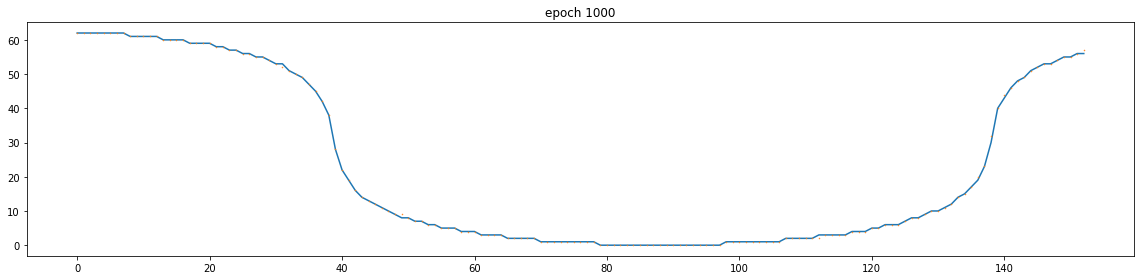

epoch 1100, loss 0.07545951008796692


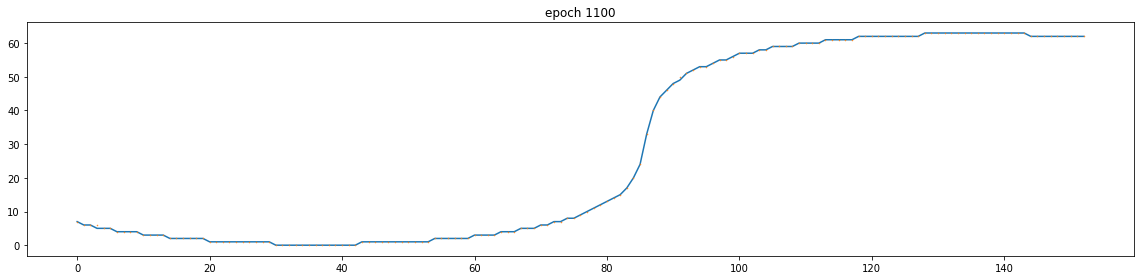

epoch 1200, loss 0.07233511656522751


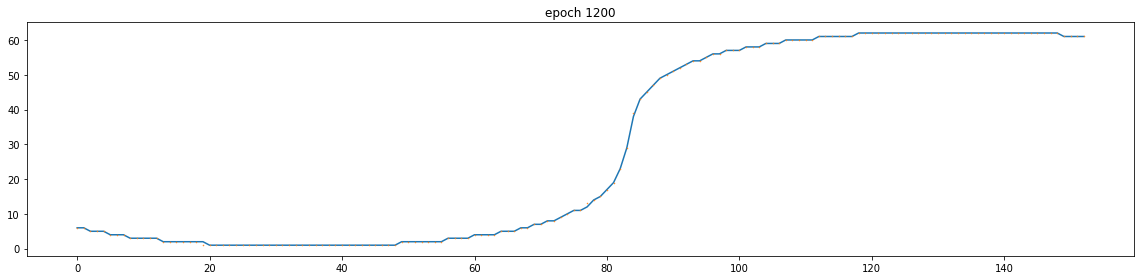

epoch 1300, loss 0.08183857053518295


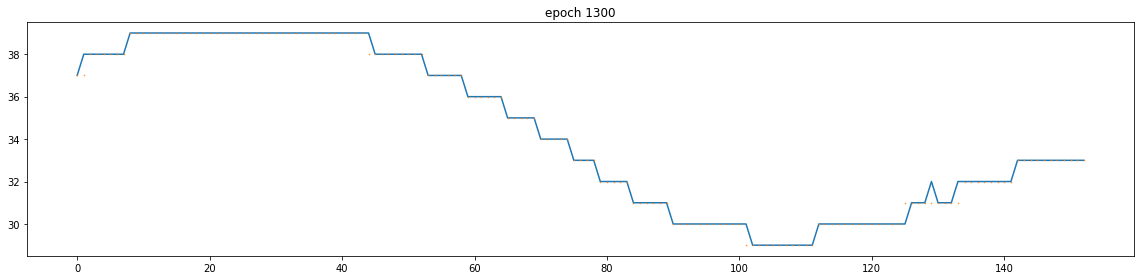

epoch 1400, loss 0.06677815318107605


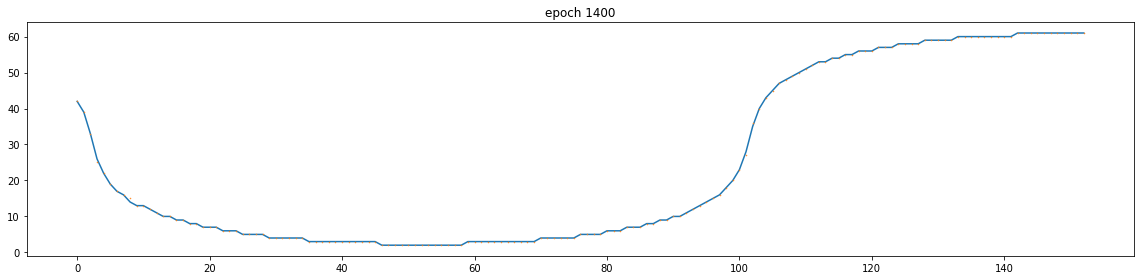

epoch 1500, loss 0.0669177919626236


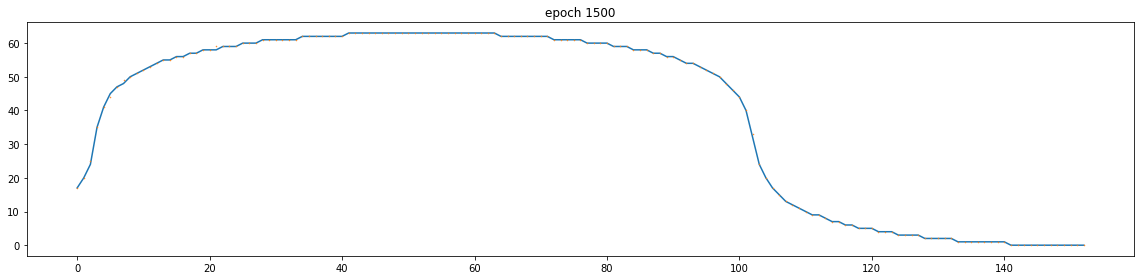

epoch 1600, loss 0.06653435528278351


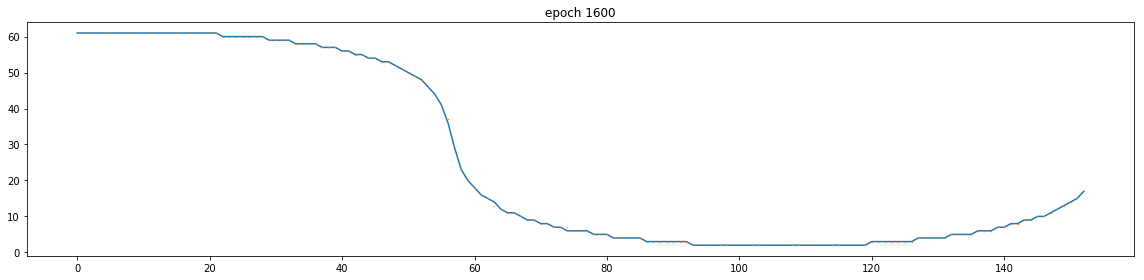

epoch 1700, loss 0.0688893273472786


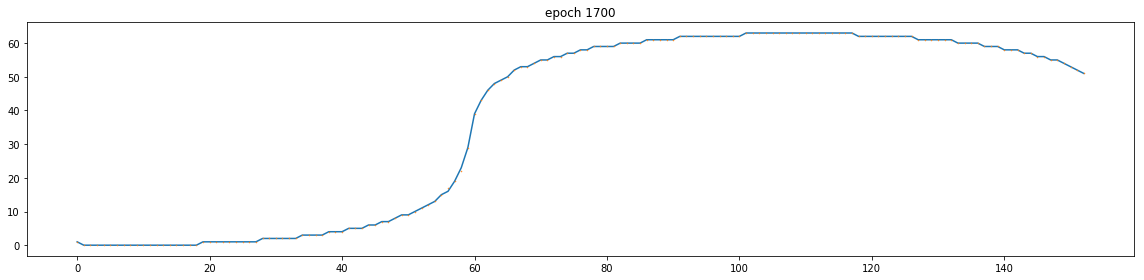

epoch 1800, loss 0.06811896711587906


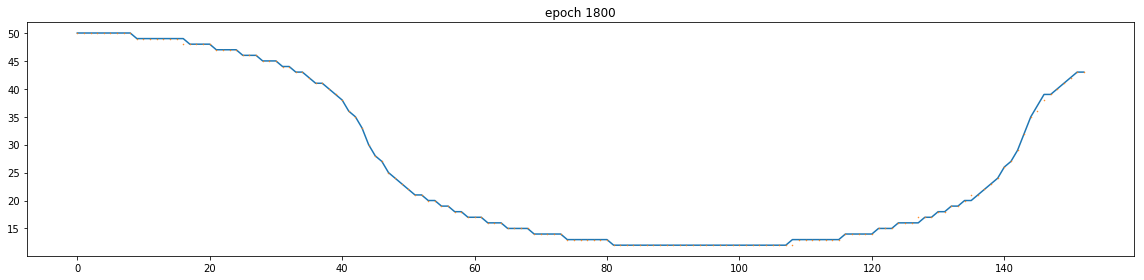

epoch 1900, loss 0.06746645271778107


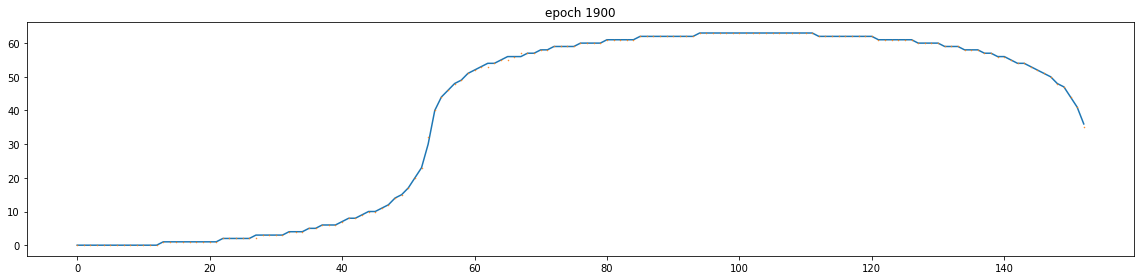

In [59]:
net = WaveNet(mu=64,n_residue=24,n_skip=128,dilation_depth=10,n_repeat=2)
net.cuda()
optimizer = optim.Adam(net.parameters(),lr=0.01)
g = sine_generator(seq_size=2200,mu=64)
batch_size = 64

loss_save = []
max_epoch = 2000
for epoch in range(max_epoch):
    optimizer.zero_grad()
    loss = 0
    for _ in range(batch_size):
        batch = next(g)
        x = batch[:-1]
        logits = net(x)
        sz = logits.size(0)
        loss += nn.functional.cross_entropy(logits, batch[-sz:].cuda())
    loss = loss/batch_size
    loss.backward()
    optimizer.step()
    loss_save.append(loss.data[0])
    # monitor progress
    if epoch%100==0:
        print('epoch {}, loss {}'.format(epoch, loss.data[0]))
        batch = next(g)
        logits = net(batch[:-1])
        _, i = logits.max(dim=1)
        plt.figure(figsize=[16,4])
        plt.plot(i.data.tolist())
        plt.plot(batch.data.tolist()[sum(net.dilations)+1:],'.',ms=1)
        plt.title('epoch {}'.format(epoch))
        plt.tight_layout()
        plt.show()

## loss function

Text(0.5,1,'loss function')

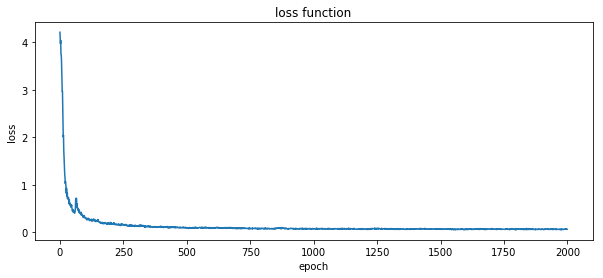

In [60]:
plt.figure(figsize=[10,4])
plt.plot(loss_save)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss function')

## data generation

In [61]:
%time y_gen = net.generate(batch, 4000)

AttributeError: 'Conv1d' object has no attribute 'LongTensor'

In [ ]:
plt.figure(figsize=[16,4])
plt.plot(y_gen)
plt.plot(batch.data.tolist(),'.',ms=2)
plt.legend(['generation','seed'])

## listen to generated sample

In [ ]:
%time y_gen = net.generate(batch, 10000)

In [ ]:
y = np.array(y_gen)
y = decode_mu_law(y, 64)
Audio(y, rate=44100)